In [58]:
# Lets compute and see the relationship between the angle and the z-axis

import MDAnalysis as md
import matplotlib.pyplot as plt
import numpy as np

# Upload and go to last frame
u = md.Universe('md_1.tpr', 'md_1_noPBC.xtc')
u.trajectory[-1]

# Select protein atoms
protein = u.select_atoms("protein")

# Check box dimensions - Should be around 16x16x20
xd, yd, zd = u.trajectory[-1].dimensions[0:3]/10

In [59]:
# Spine Algo
def get_spine(cds, n):
    zmin = min(cds[:, 2])
    zmax = max(cds[:, 2])
    deltaz = (zmax - zmin)/n
    center_z = np.zeros((n, 3))
    for i in range(n):
        # Get ranges of z
        z_low = deltaz*i + zmin
        z_upp = deltaz + z_low
        z_c = z_low + deltaz/2

        # Group atoms
        mask = (cds[:, 2] >= z_low) & (cds[:, 2] < z_upp)
        selected = cds[mask]

        center_z[i] = [np.mean(selected[:, 0]), np.mean(selected[:, 1]), z_c]
    
    return center_z

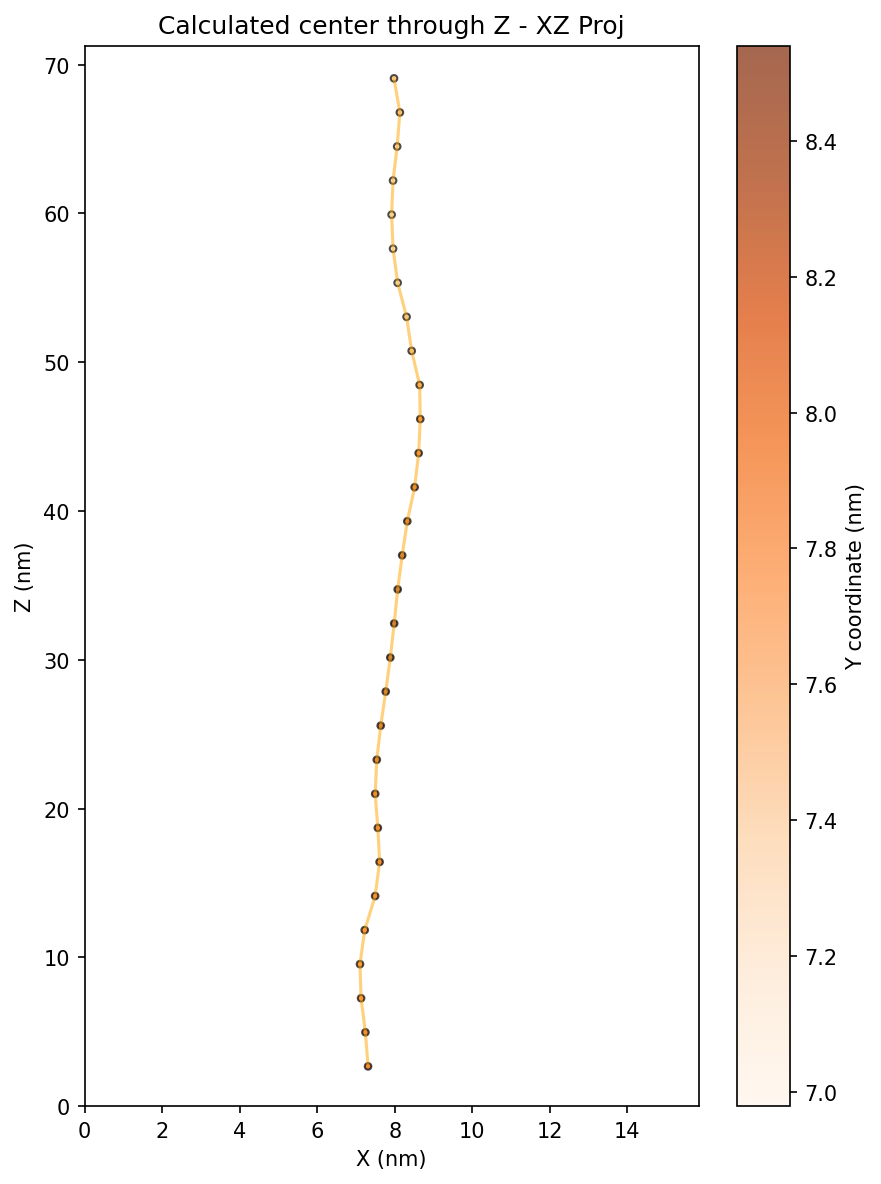

In [95]:
# Get the center before computing the angle
backbones = protein.select_atoms("backbone")
coords = backbones.positions/10 

whole_spine = get_spine(coords, 30)

plt.figure(figsize=(6,8), dpi=150)
plt.plot(whole_spine[:, 0], whole_spine[:,2], color='orange', alpha=0.5)
sc = plt.scatter(whole_spine[:, 0], whole_spine[:,2], c=whole_spine[:,1], cmap='Oranges', s=10, edgecolor='k', alpha=0.7)
plt.colorbar(sc, label='Y coordinate (nm)')
plt.xlabel("X (nm)")
plt.ylabel("Z (nm)")
plt.title("Calculated center through Z - XZ Proj")
plt.xlim(0, xd)
plt.ylim(0, zd)
plt.tight_layout()
plt.show()

In [61]:
# Vague Approximation
x_c = np.mean(whole_spine[:, 0])
y_c = np.mean(whole_spine[:, 1])

In [62]:
# Get the representation (mean) from the molecule
mol = 4
chains = protein.fragments[3*mol:3*mol + 3]
colmol = chains[0] + chains[1] + chains[2]
coords = colmol.positions / 10

center_z_test = get_spine(coords, 30)


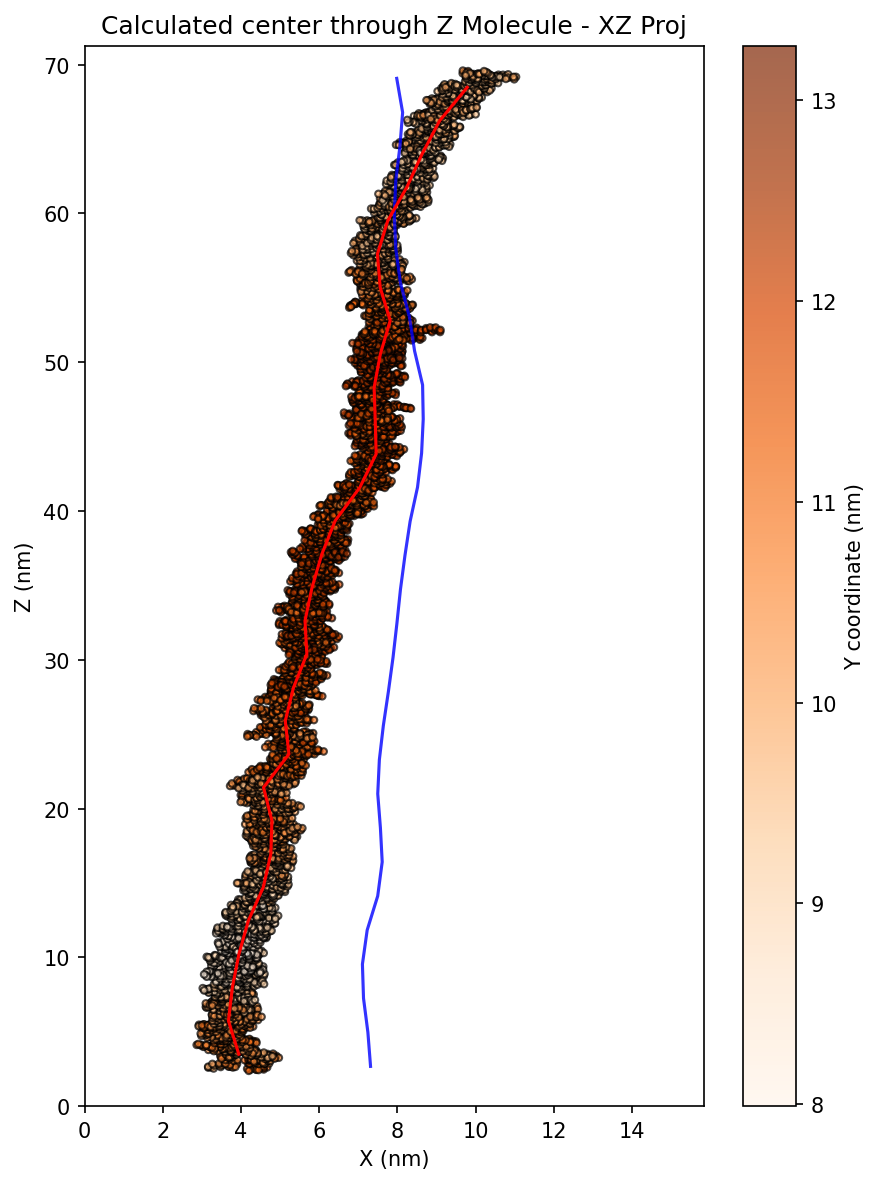

In [63]:
plt.figure(figsize=(6,8), dpi=150)
plt.plot(whole_spine[:, 0], whole_spine[:,2], color='b', alpha=0.8)
plt.plot(center_z_test[:, 0], center_z_test[:, 2], color='r')
sc = plt.scatter(coords[:, 0], coords[:,2], c=coords[:,1], cmap='Oranges', s=10, edgecolor='k', alpha=0.7)
plt.colorbar(sc, label='Y coordinate (nm)')
plt.xlabel("X (nm)")
plt.ylabel("Z (nm)")
plt.title("Calculated center through Z Molecule - XZ Proj")
plt.xlim(0, xd)
plt.ylim(0, zd)
plt.tight_layout()
plt.show()

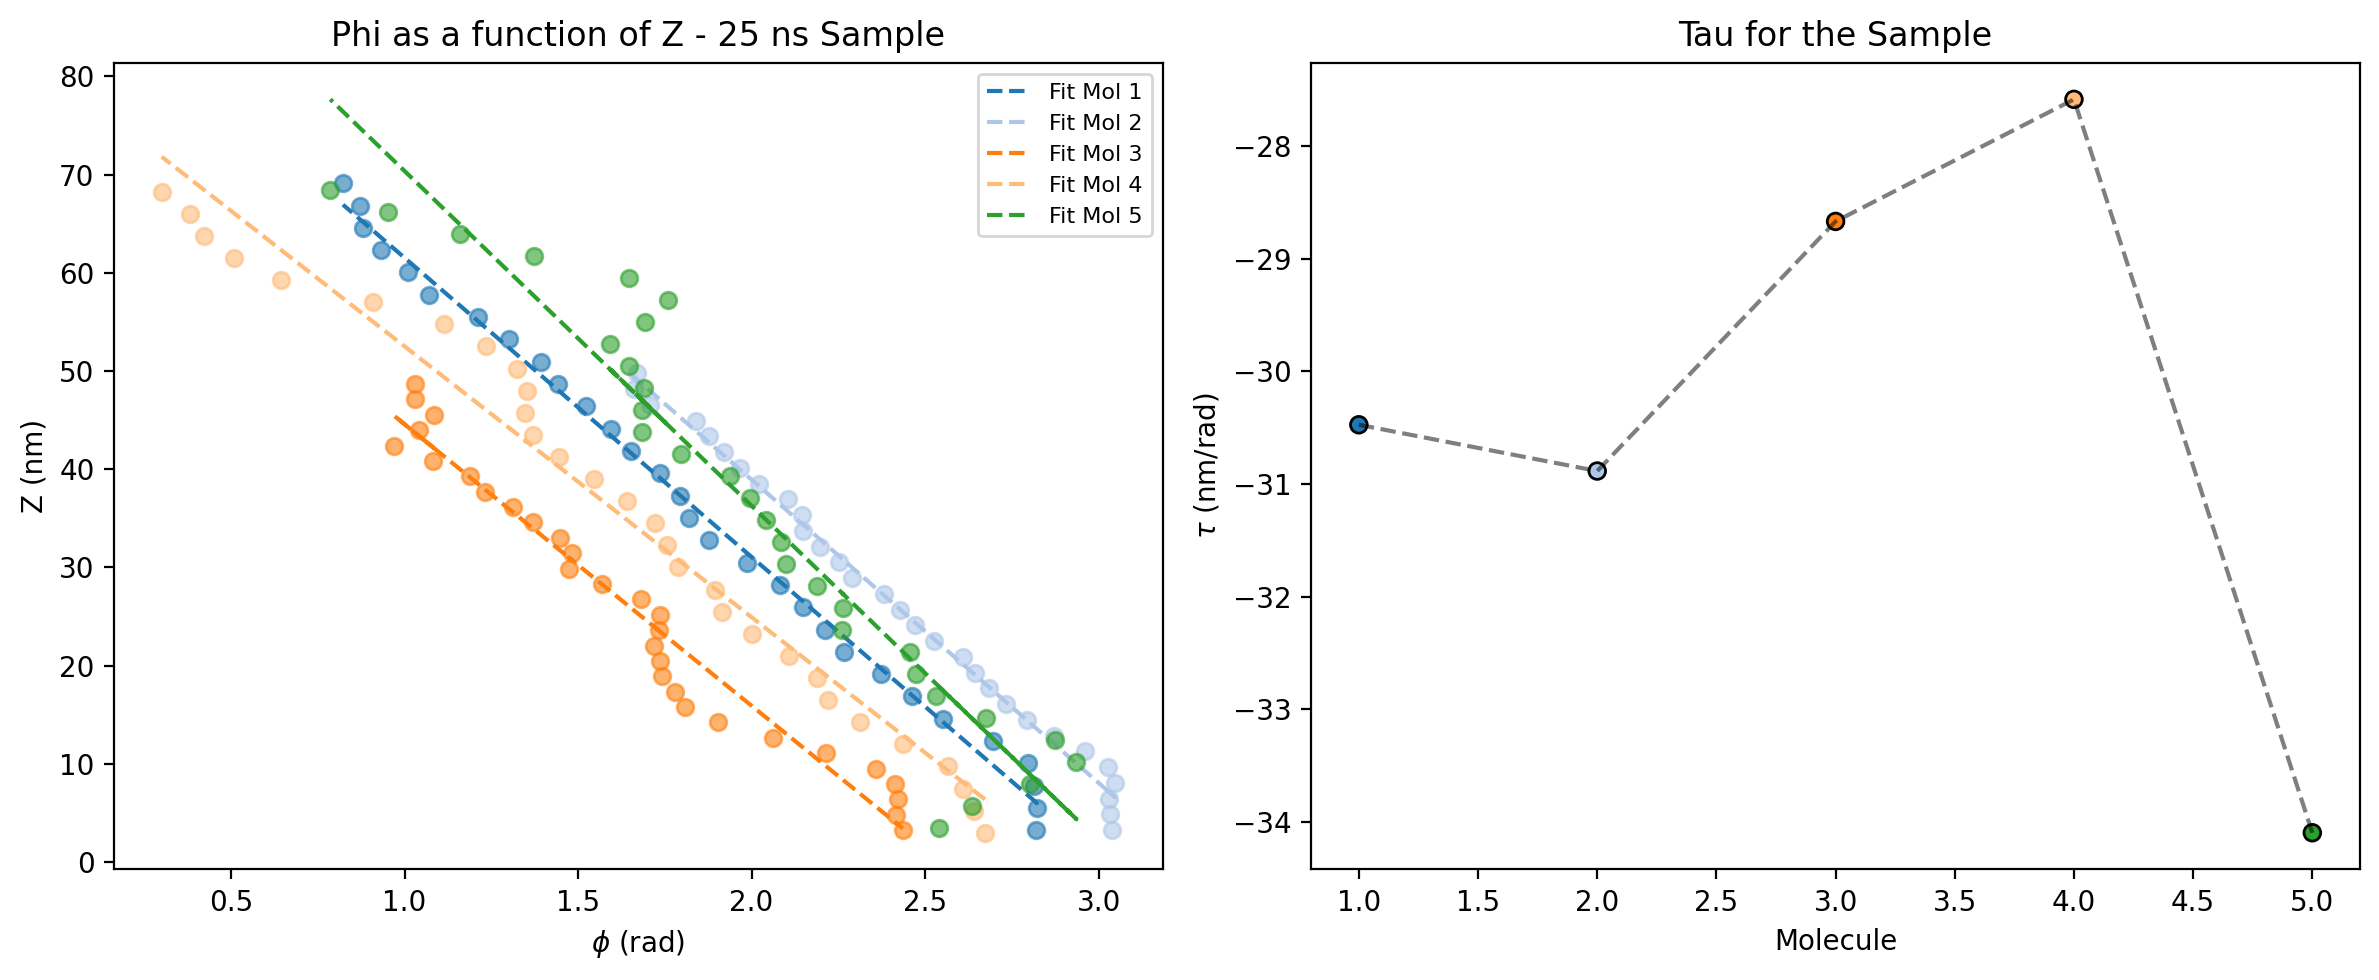

In [76]:
# Get Number of Molecules
sample = 5
num_mol = int((protein.fragindices[-1] + 1)/3)

if sample <= num_mol:
    num_mol = sample

all_centers = [] 

for mol in range(num_mol):
    # Get atoms
    chains = protein.fragments[3*mol:3*mol + 3]
    colmol = chains[0] + chains[1] + chains[2]

    # Coords
    coords = colmol.positions / 10

    # Spine
    center_z_p = get_spine(coords , 30)
    all_centers.append(center_z_p)

# Compute Angle and See relation
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=200)

tau = np.zeros(num_mol)

cmap = plt.get_cmap("tab20")
colors = [cmap(i % 20) for i in range(num_mol)]

# --- Phi vs Z ---
for i in range(num_mol):
    center = all_centers[i]
    x = center[:, 0] - x_c  # Reference to center
    y = center[:, 1] - y_c
    z = center[:, 2]
    
    phi = np.arctan2(y, x)

    tau[i], b = np.polyfit(phi, z, 1)
    fit = np.poly1d((tau[i], b))

    color = colors[i]
    axs[0].plot(phi, z, 'o', color=color, alpha=0.6)
    axs[0].plot(phi, fit(phi), '--', color=color, label=f"Fit Mol {i+1}")

axs[0].set_xlabel(r"$\phi$ (rad)")
axs[0].set_ylabel("Z (nm)")
axs[0].set_title("Phi as a function of Z - 25 ns Sample")
axs[0].legend(fontsize=8)

# --- Tau ---
axs[1].scatter(np.arange(1, num_mol + 1), tau, color=colors[0:num_mol], edgecolor='k')
axs[1].plot(np.arange(1, num_mol + 1), tau, '--', alpha=0.5, color='k')
axs[1].set_xlabel("Molecule")
axs[1].set_ylabel(r"$\tau$ (nm/rad)")
axs[1].set_title("Tau for the Sample")

plt.tight_layout()
plt.show()

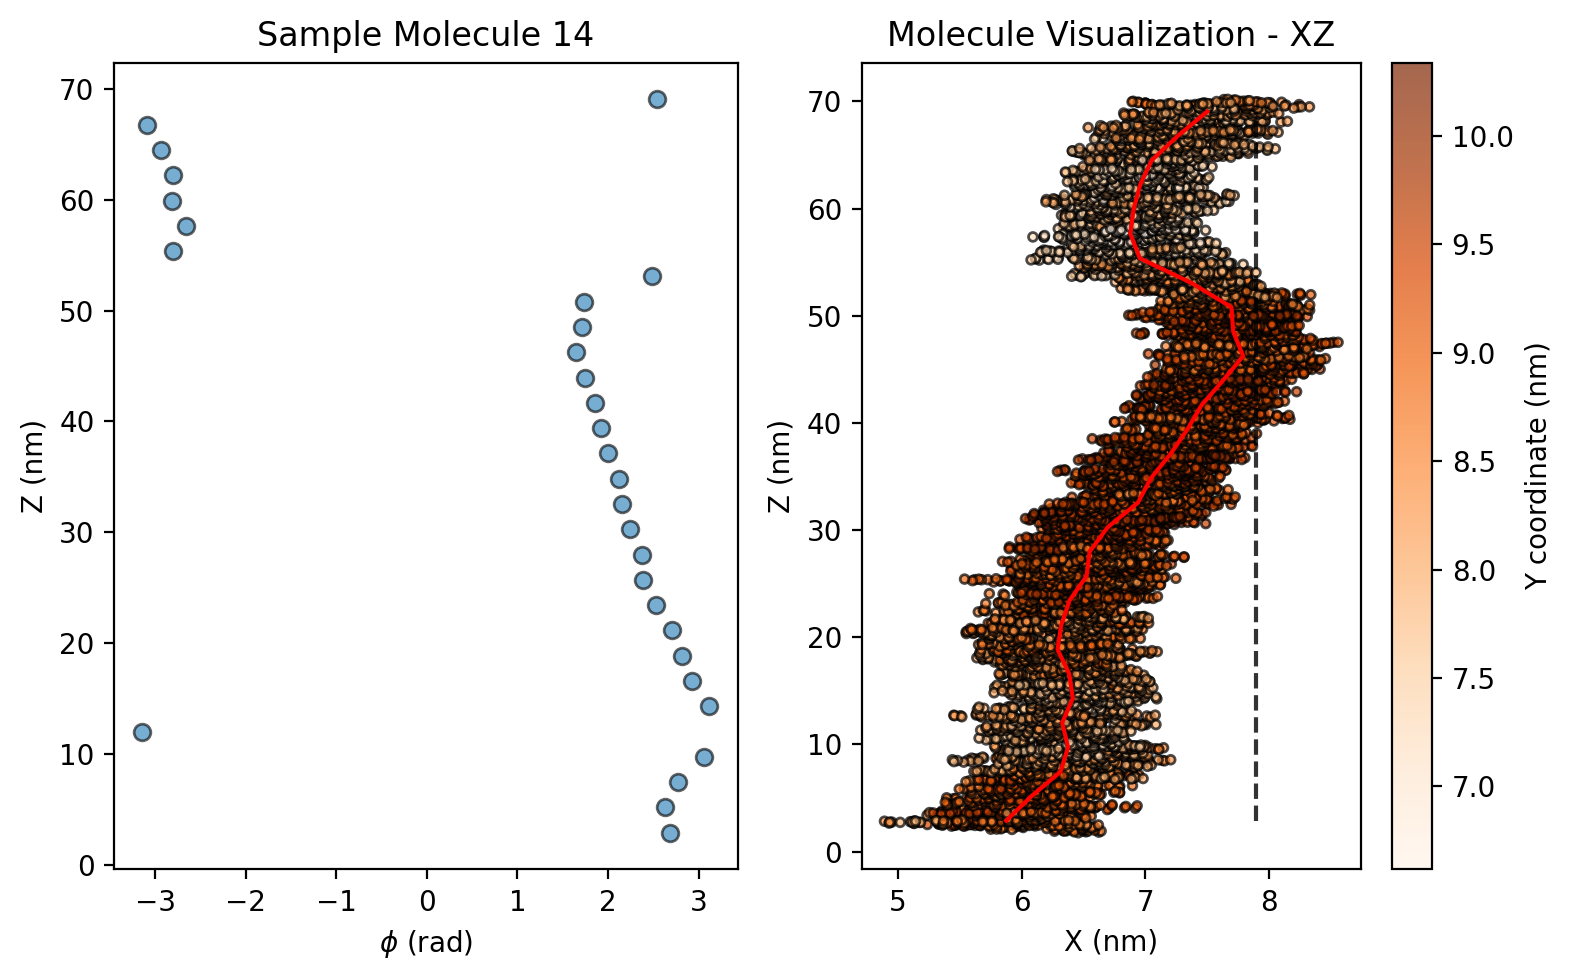

In [105]:
# Phi might do Jumps
mol = 14

chains = protein.fragments[3*mol:3*mol + 3]
colmol = chains[0] + chains[1] + chains[2]

# Coords
coords = colmol.positions / 10

center_z = get_spine(coords , 30)
x = center_z[:, 0] - x_c  # Reference to center
y = center_z[:, 1] - y_c
z = center_z[:, 2]

phi = np.arctan2(y, x)

fig, axs = plt.subplots(1, 2, figsize=(8, 5), dpi=200)

# Sample molecule (phi, z) relation
axs[0].scatter(phi, z, alpha=0.6, edgecolor='k', label="Raw "+r"$\phi$")
axs[0].set_xlabel(r"$\phi$ (rad)")
axs[0].set_ylabel("Z (nm)")
axs[0].set_title(f"Sample Molecule {mol}")

# Real Vis of Molecule
axs[1].plot(center_z[:, 0], center_z[:, 2], color='r')
axs[1].plot(x_c*np.ones(30), center_z[:, 2], '--', color='k', alpha=0.8)
sc = axs[1].scatter(coords[:, 0], coords[:, 2], c=coords[:, 1], cmap='Oranges', s=10, edgecolor='k', alpha=0.7)
fig.colorbar(sc, ax=axs[1], label='Y coordinate (nm)')
axs[1].set_xlabel("X (nm)")
axs[1].set_ylabel(r"Z (nm)")
axs[1].set_title("Molecule Visualization - XZ")

plt.tight_layout()
plt.show()

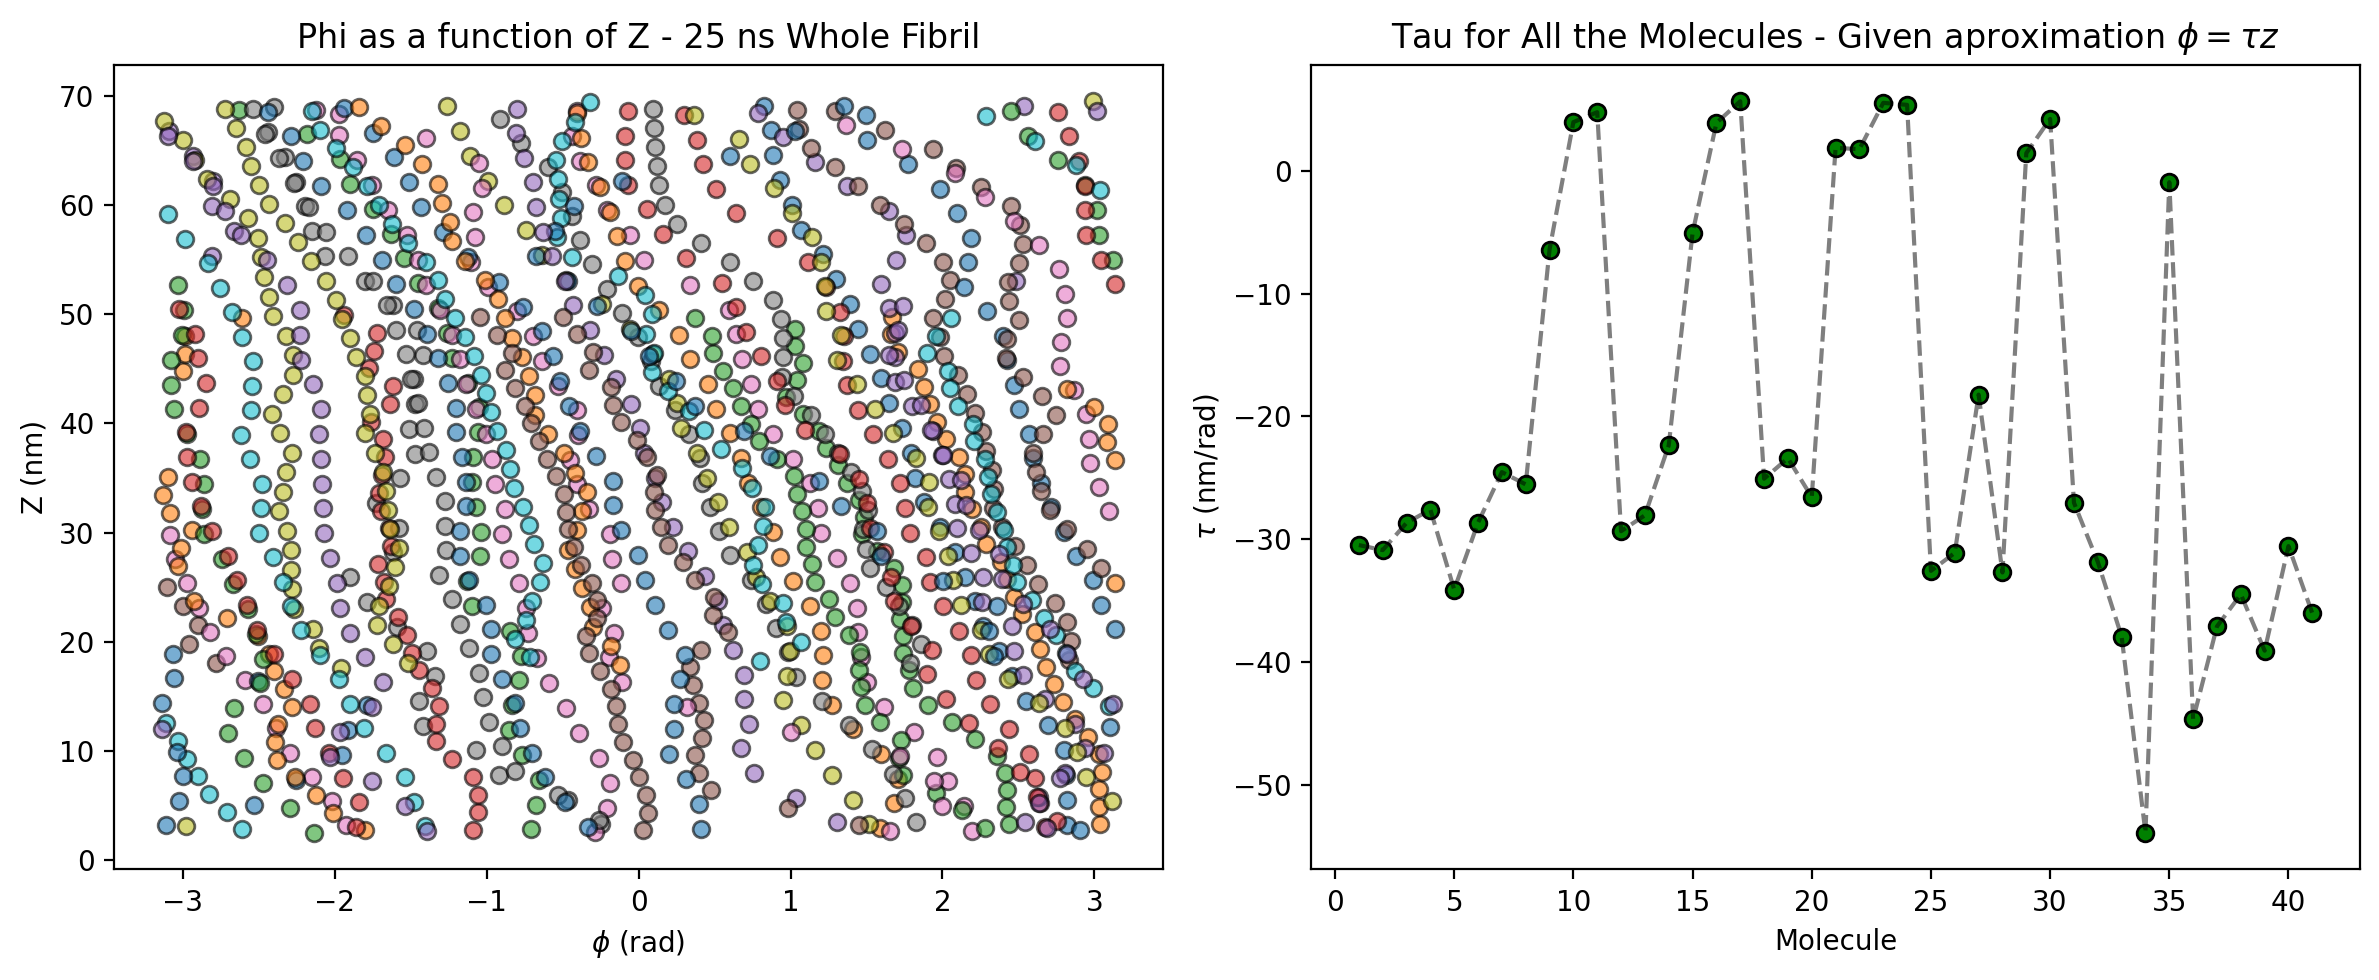

In [102]:
# Whole Tau Spectrum
num_mol = int((protein.fragindices[-1] + 1)/3)
tau_tot = np.zeros(num_mol)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=200)

for mol in range(num_mol):
    # Get atoms
    chains = protein.fragments[3*mol:3*mol + 3]
    colmol = chains[0] + chains[1] + chains[2]

    # Coords
    coords = colmol.positions / 10

    # Spine
    center_zp = get_spine(coords , 30)
    x = center_zp[:, 0] - x_c  # Reference to center
    y = center_zp[:, 1] - y_c
    z = center_zp[:, 2]

    phi = np.arctan2(y, x)
    tau_tot[mol], _ = np.polyfit(phi, z, 1)

    axs[0].scatter(phi, z, alpha=0.6, edgecolor='k')

axs[0].set_xlabel(r"$\phi$ (rad)")
axs[0].set_ylabel("Z (nm)")
axs[0].set_title("Phi as a function of Z - 25 ns Whole Fibril")

axs[1].scatter(np.arange(1, num_mol + 1), tau_tot, color='g', edgecolor='k')
axs[1].plot(np.arange(1, num_mol + 1), tau_tot, '--', alpha=0.5, color='k')
axs[1].set_xlabel("Molecule")
axs[1].set_ylabel(r"$\tau$ (nm/rad)")
axs[1].set_title("Tau for All the Molecules - Given aproximation " + r"$\phi = \tau z$")

plt.tight_layout()
plt.show()
